# Chambolle-Pock Algorithm 

This note aims at showing how to solve LASSO by using [Chambolle-Pock (CP)](https://odl.readthedocs.io/math/solvers/nonsmooth/chambolle_pock.html) algorithm.
CP is a primal-dual method solving both the primal and dual problem at the same time. However, it is important to notice that the iterative dual solutions are not guaranteed to be feasible.

## Basic of Chambolle-Pock Algorithm

**Problem:** 
Primal and dual problem 
$$\min_{x} \quad f(Ax) + g(x)$$
$$\max_{u} \quad -f^*(u) - g^*(-A^Tu)$$

**Initialization:** $\tau, \sigma>0, \theta\in [0,1]$, $\overline x_0 = x_0\in X$ and $u_0 \in V$. Here one should choose $\tau=\sigma < 1/||A||$.

**Iteration:**
$$
\begin{aligned}
u^{(k+1)} & = \text{prox}_{\sigma f^*}(u^{(k)} + \sigma A\overline x^{(k)})\\
x^{(k+1)} & = \text{prox}_{\tau g}(x^{(k)} - \tau A^T u^{(k+1)})\\
\overline x^{(k+1)} & = x^{(k+1)} +\theta (x^{(k+1)} - x^{(k)})
\end{aligned}
$$


## Applying on LASSO

The LASSO setup has primal and dual problem defined  as follows
$$\min_{x} \quad \frac{1}{2}||b-Ax||^2_2+ \lambda ||x||_1$$
$$\max_{u} \quad \frac{1}{2}||b||^2_2 - \frac{1}{2}||b-u||^2_2 - I(||A^Tu||_\infty\leq \lambda)$$

Here, the dual optimal solution $u^\star$ is the closest point projection of $b$ onto $U = \{u: ||A^Tu||_\infty\leq \lambda\}$.
This dual problem is a little bit different from above dual problem since we set $$u:= -u,$$ this is possible since $U$ is symmetric, i.e. $-U=U$. 
We obtain such above dual problem since 

$$f(v) = \frac{1}{2}||b-v||^2_2, \quad f^*(u) = \frac{1}{2}||b+u||^2_2 - \frac{1}{2}||b||^2_2 $$

and 
$$g(x) =  \lambda ||x||_1, \quad g^*(-A^Tu) = \lambda I(||\frac{-A^Tu}{\lambda}||_\infty\leq 1) $$


Let $u^+ = prox_{\sigma f^*} (u)$, then we should have 

$$\sigma(u^++b) + (u^+-u) =0 \Longleftrightarrow u^+ = \frac{u - \sigma b}{1+\sigma}$$

and let $x^+ = prox_{\tau g^*} (x)$, then 

$$x^+ = sign(x) [|x| - \tau \lambda]_+$$

**Remark.** Here since the dual solutions $u$ obtained from the CP are not dual feasible, we can not use the dual gap as a stopping metric/condition as usual. Here we consider another quite interesting metric as follows. Let $P$ be the hyper-plane defined by $\{u: \langle Ax^\star, u\rangle = \lambda ||x^\star||_1\}$. Then it is clear by the optimality condition that $u^\star\in P$, So for a point $v$ converging to $u^\star$, we can quantify the convergence of $v$ by $(||v_P-u^\star||, ||v -v_P||)$. Here $v=b-Ax$ or $v=u$.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pypoman
from scipy.spatial import ConvexHull

def get_atom(angle):
    return np.array([np.cos(angle), np.sin(angle)])

def get_setup():
	np.random.seed(124)
	# Generate random A matrix of size mxn
	degrees = np.array([0, 30, 80, 90, 120])    
	# degrees = np.array([0, 90, 120])        
            
	radians = degrees * np.pi /180
	atoms = [get_atom(alpha) for alpha in radians]
	A = np.vstack(atoms).T

	# Generate random x0 vector of size n
	m, n = A.shape
	k = np.random.choice(np.arange(n), 3)
	x0 = np.zeros(n)
	x0[k] = np.random.rand(3)

	# Compute b vector such that Ax0 = b
	b = np.dot(A, x0)

	# define parameters and 
	lbd_max = np.max(np.dot(A.T, b))
	lbd = 0.5 * lbd_max 
	data = {
         "b": b, 
         "A": A,
         "lbd": lbd, 
         "x0": x0      
	}
	return data

data  = get_setup()
A = data["A"]
b = data["b"]
lbd = data["lbd"]
x0 = data["x0"]
b = np.array([1,1])

In [118]:
def dual_prox(b, p, sigma):
	return (p - sigma*b )/ (1+sigma)

def primal_prox(z, lbd, tau):
	return np.sign(z) * np.maximum(np.abs(z) - lbd*tau, 0.)

def lasso_chambolle_pock(A, b, lbd, max_iters=100):
	x0 = np.zeros(A.shape[1])
	u0 = np.zeros(A.shape[0])
	lip = np.sqrt((A**2).sum())
	sigma = 0.5/lip
	tau = 0.5/lip
	theta=1

	x = x0.copy()
	u = u0.copy()
	xbar = x0.copy()
	x_list = []
	u_list = []

	for i in range(max_iters):
		xpre = x.copy()
		u = dual_prox(b, p= u + sigma * A @ xbar, sigma=sigma)
		x = primal_prox(z= xpre - tau * A.T @ u, lbd=lbd, tau=tau)
		xbar = x + theta * (x-xpre)

		x_list += [x]
		u_list += [u]

	x_array= np.vstack(x_list).T
	u_array = np.vstack(u_list).T # change sign of u
	return x_array, u_array



x_array, u_array = lasso_chambolle_pock(A, b, lbd, max_iters=50)
u_array = -u_array
r_array = b.reshape(2, 1) - A @ x_array


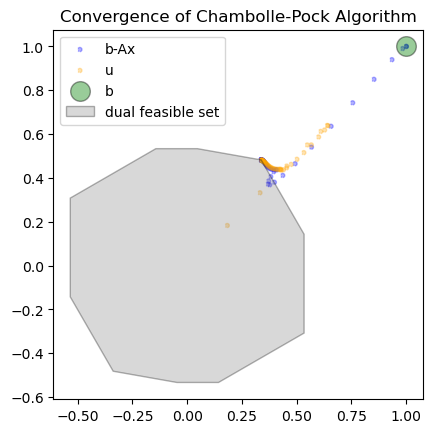

In [119]:
def plot_feasible_set(A, b, lbd):
	matrix = np.hstack([A, -A]).T
	bound = np.ones(matrix.shape[0])*lbd
	vertices = pypoman.compute_polytope_vertices(matrix, bound)
	vertices = np.vstack(vertices) # shape (n, 2)
	indices = ConvexHull(vertices).vertices
	vertices = vertices[indices, :]

	plt.fill(vertices[:, 0], vertices[:, 1], color="gray",
			alpha=0.3, edgecolor='black', linewidth=1,
			label="dual feasible set")


# plot 
plt.scatter(r_array[0], r_array[1], c="blue", label="b-Ax", ls="-.", marker=".", alpha=0.3)
plt.scatter(u_array[0], u_array[1], c="orange", label="u", ls="-.", marker=".", alpha=0.3)
plt.scatter(b[0], b[1], c="green", label="b", alpha=0.4, edgecolors="black", s=200)
plot_feasible_set(A, b, lbd)
plt.legend()
plt.axis('scaled')
plt.title("Convergence of Chambolle-Pock Algorithm")
plt.show() 

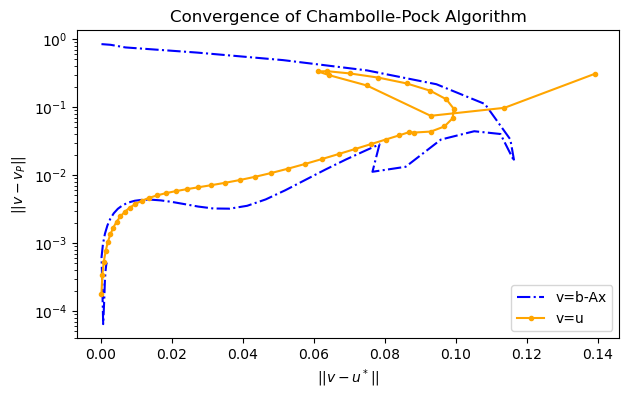

In [120]:
def projection_onto_plane(v, g, s):
    # Given plane P: <g, u> <= s 
	# Find projection w of v onto P
	# Then: w = v - d * g/||g|| with d = (<g, v> - s)/||g|| 
	gnorm = np.linalg.norm(g)
	d = ((g*v).sum() - s)/gnorm 
	w = v - d* g/gnorm 
	return w 

# optimal plane <Ax_opt, u> <= lbd * ||x_opt||_1 
u_opt = u_array[:, -1]
x_opt = x_array[:, -1]
g = b - u_opt 
s = lbd* np.abs(x_opt).sum()
r_proj = np.vstack([projection_onto_plane(v=r_array[:, i], g=g, s=s) for i in range(x_array.shape[1])]).T
r_coord = np.vstack([(np.linalg.norm(r_proj[:, i] - u_opt), np.linalg.norm(r_proj[:, i] -r_array[:, i])) for i in range(x_array.shape[1])]).T 
u_proj = np.vstack([projection_onto_plane(v=u_array[:, i], g=g, s=s) for i in range(x_array.shape[1])]).T
u_coord = np.vstack([(np.linalg.norm(u_proj[:, i] - u_opt), np.linalg.norm(u_proj[:, i] -u_array[:, i])) for i in range(x_array.shape[1])]).T 


fig, axs = plt.subplots(1, 1, figsize=(7, 4))
ax=axs
ax.plot(r_coord[0], r_coord[1],  label="v=b-Ax", color="blue", ls="-.")
ax.plot(u_coord[0], u_coord[1],  label="v=u", color="orange", marker=".")
ax.legend()
ax.set_xlabel("$||v-u^*||$")
ax.set_ylabel("$||v-v_P||$")
ax.set_yscale("log")
ax.set_title("Convergence of Chambolle-Pock Algorithm")
plt.show()

